<a href="https://colab.research.google.com/github/jhsrojasro/ML-3A-project/blob/main/ML_Project_Game_recommendations_Using_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1> Machine Learning and Differentiable Programming Project: Node Embedding based Recommender System </h1>
<h3> Jhon Sebastian Rojas Rodriguez </h2>
</center>


In [ ]:
!pip install dgl

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.3 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle
import itertools
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import os
import matplotlib.pyplot as plt
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
workdir = '/home/pc-techlab-3/Documents/ml_rojas/'

# Data Preprocesing

In [ ]:
users_df = pd.read_csv(workdir+'users.csv')
# users_df = users_df[ users_df['user_id'].isin( pd.unique(recommendations_df['user_id']) ) ]
# users_df = users_df.drop(labels=["reviews"], axis=1)
n_users = users_df.shape[0]
print("Number of users: ", n_users)
users_df.head()

Number of users:  13786778


,user_id,products,reviews
0,7090995,359,0
1,13511788,156,1
2,8444727,329,4
3,4632233,176,3
4,4968781,98,2


In [ ]:
games_df = pd.read_csv(workdir+'games.csv')
# games_df = games_df.sort_values(by=['app_id'])
# games_df = games_df[ games_df['app_id'].isin( pd.unique(recommendations_df['app_id']) ) ]
games_df = games_df[["app_id", "title"]]
games_df = games_df.reset_index()
games_df.index = games_df['app_id']
games_df = games_df.drop(columns=['app_id'])
games_df = games_df.rename(columns={"index":"node_index"})
games_df['node_index'] = games_df['node_index'] + n_users
n_games = games_df.shape[0]
print("Number of games: ", n_games)
node_ind_dict = games_df['node_index'].to_dict()
games_df.head()

Number of games:  50872


,node_index,title
app_id,,
13500,13786778,Prince of Persia: Warrior Within™
22364,13786779,BRINK: Agents of Change
113020,13786780,Monaco: What's Yours Is Mine
226560,13786781,Escape Dead Island
249050,13786782,Dungeon of the ENDLESS™


In [ ]:
recommendations_df = pd.read_csv(workdir+'recommendations.csv')
# recommendations_df = recommendations_df.sort_values(by=['user_id']).head(N_TRANSACTIONS)
recommendations_df = recommendations_df[["app_id", "user_id", "is_recommended"]]
recommendations_df['is_recommended'] = recommendations_df['is_recommended'].map({True : 1, False : -1})
recommendations_df['app_id'] = recommendations_df['app_id'].map(node_ind_dict)
recommendations_df.head()

,app_id,user_id,is_recommended
0,13835022,49625,1
1,13800690,2482,-1
2,13800051,243409,1
3,13801114,248701,1
4,13834668,22902,1


# Dataset Creation

In [ ]:
n_users = users_df.shape[0]
n_games = users_df.shape[0]
n_nodes =  n_games + n_users
n_nodes

27573556

In [ ]:
from dgl.data import DGLDataset

class SteamGameRatingsDataset(DGLDataset):
  def __init(self):
    super().__init__(name="steam_game_ratings")

  def process(self):
    edges_features = T.from_numpy(recommendations_df['is_recommended'].to_numpy())

    edges_src = T.from_numpy(recommendations_df['user_id'].to_numpy())
    edges_dst = T.from_numpy(recommendations_df['app_id'].to_numpy())

    self.graph = dgl.graph(
        (edges_src, edges_dst), num_nodes=n_nodes
    )

    self.graph.edata["weight"] = edges_features

  def __getitem__(self, i):
    return self.graph

  def __len__(self):
    return 1

In [ ]:
dataset = SteamGameRatingsDataset(name="steam_game_ratings")
g = dataset[0]

print(g)

Graph(num_nodes=27573556, num_edges=38354101,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.int64)})


# Dataset Split

In [ ]:
u, v = g.edges()

eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
validation_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size - validation_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
validation_pos_u, validation_pos_v = u[eids[test_size : test_size + validation_size]], v[eids[test_size : test_size + validation_size]]
train_pos_u, train_pos_v = u[eids[test_size + validation_size:]], v[eids[test_size+validation_size:]]

In [ ]:
neg_u , neg_v = np.random.choice(n_users , g.num_edges()) , np.random.choice(n_games , g.num_edges()) + n_users
contained_in_g = g.has_edges_between(neg_u, neg_v)
while contained_in_g.any().item():
  trues_indexes = T.where(contained_in_g == True)[0]
  n_trues = trues_indexes.shape[0]
  rand_u, rand_v = np.random.choice(n_users , n_trues) , np.random.choice(n_games , n_trues) + n_users
  neg_u[trues_indexes] , neg_v[trues_indexes] = rand_u, rand_v
  contained_in_g = g.has_edges_between(neg_u, neg_v)

In [ ]:
neg_eids = np.random.choice(len(neg_u), g.num_edges())

test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)

validation_neg_u, validation_neg_v = (
    neg_u[neg_eids[test_size : test_size+validation_size]],
    neg_v[neg_eids[test_size : test_size+validation_size]],
)

train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

In [ ]:
train_g = dgl.remove_edges(g, eids[:test_size + validation_size])

validation_g = dgl.remove_edges(g, eids[:test_size])
validation_g = dgl.remove_edges(g, np.concatenate((eids[:test_size], eids[test_size + validation_size:])))

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

validation_pos_g = dgl.graph((validation_pos_u, validation_pos_v), num_nodes=g.number_of_nodes())
validation_neg_g = dgl.graph((validation_pos_u, validation_pos_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
pickle.dump(train_g, open(workdir+'train_graph.pickle', 'wb'))
pickle.dump(train_pos_g, open(workdir+'train_pos_g.pickle', 'wb'))
pickle.dump(train_neg_g, open(workdir+'train_neg_g.pickle', 'wb'))
pickle.dump(validation_pos_g, open(workdir+'validation_pos_g.pickle', 'wb'))
pickle.dump(validation_neg_g, open(workdir+'validation_neg_g.pickle', 'wb'))
pickle.dump(test_pos_g, open(workdir+'test_pos_g.pickle', 'wb'))
pickle.dump(test_neg_g, open(workdir+'test_neg_g.pickle', 'wb'))

# Create Model




In [ ]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

# Traing GNN

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = T.cat([pos_score, neg_score])
    labels = T.cat([T.ones(pos_score.shape[0]), T.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels, reduction='mean')

def compute_auc(pos_score, neg_score):
    scores = T.cat([pos_score, neg_score]).numpy()
    labels = T.cat(
        [T.ones(pos_score.shape[0]), T.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
train_g = pickle.load(open(workdir+'train_graph.pickle', 'rb'))
train_pos_g = pickle.load(open(workdir+'train_pos_g.pickle', 'rb'))
train_neg_g = pickle.load(open(workdir+'train_neg_g.pickle', 'rb'))
validation_pos_g = pickle.load(open(workdir+'validation_pos_g.pickle', 'rb'))
validation_neg_g = pickle.load(open(workdir+'validation_neg_g.pickle', 'rb'))
test_pos_g = pickle.load(open(workdir+'test_pos_g.pickle', 'rb'))
test_neg_g = pickle.load(open(workdir+'test_neg_g.pickle', 'rb'))

In [ ]:
epochs = 100
learning_rate = 0.003
embeding_size = 16

In [ ]:
model = GraphSAGE(1, embeding_size)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

In [ ]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=learning_rate)

# ----------- 4. training -------------------------------- #
all_logits = []
train_losses = []
validation_losses = []
for e in tqdm(range(epochs)):
    # forward
    h = model(train_g, train_g.nodes().view(-1,1).float())

    # Validation
    validation_pos_score = pred(validation_pos_g, h)
    validation_neg_score = pred(validation_neg_g, h)
    validation_loss = compute_loss(validation_pos_score, validation_neg_score)
    validation_losses.append(validation_loss.item())


    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if e % 5 == 0:
    print('In epoch {}, loss: {}, validation loss: {}'.format(e, loss, validation_loss))



# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

  0%|          | 0/100 [00:00<?, ?it/s]

In epoch 0, loss: 604483226697728.0, validation loss: 572541689135104.0
In epoch 1, loss: 577223136378880.0, validation loss: 543238603669504.0
In epoch 2, loss: 551017527640064.0, validation loss: 515331281911808.0
In epoch 3, loss: 525825967390720.0, validation loss: 488846164754432.0
In epoch 4, loss: 501638523518976.0, validation loss: 463661382500352.0
In epoch 5, loss: 478451337265152.0, validation loss: 439700196163584.0
In epoch 6, loss: 456253033676800.0, validation loss: 416889658408960.0
In epoch 7, loss: 435024386064384.0, validation loss: 395161049759744.0
In epoch 8, loss: 414740966801408.0, validation loss: 374454207119360.0
In epoch 9, loss: 395377509400576.0, validation loss: 354730609999872.0
In epoch 10, loss: 376909284245504.0, validation loss: 335970058633216.0
In epoch 11, loss: 359310420869120.0, validation loss: 318157252198400.0
In epoch 12, loss: 342552196677632.0, validation loss: 301274675281920.0
In epoch 13, loss: 326602768515072.0, validation loss: 285299

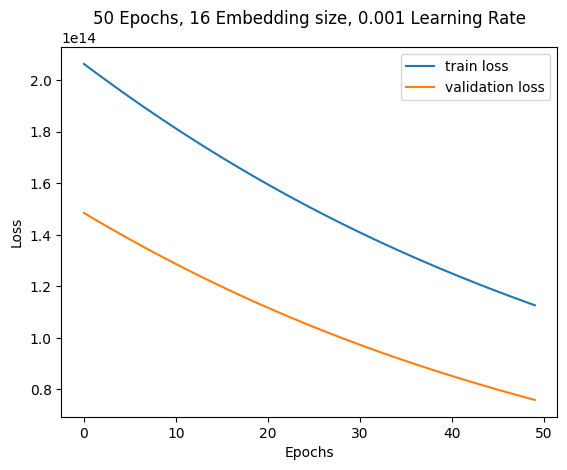

In [ ]:
plt.plot(np.arange(epochs), train_losses, label='train loss')
plt.plot(np.arange(epochs), validation_losses, label='validation loss')
plt.title('{} Epochs, {} Embedding size, {} Learning Rate'.format(epochs, embeding_size, learning_rate))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Use trained model to make recommendations

#